In [1]:
import xsimlab as xs
from episimlab.models import ExampleSIR
from episimlab.foi import BaseFOI
from episimlab.utils import visualize_compt_graph
import networkx as nx

# Episimlab Tutorial
----

This notebook will provide a brief tutorial in basic model building using Episimlab version 2.

## Installation

To install Episimlab, issue:
```bash
pip install episimlab
```

...or install the development version from the GitHub repo:
```bash
pip install git+https://github.com/eho-tacc/episimlab
```

## Run an Existing SIR Model
----

The package includes several pre-built models as examples/starting points. Here, we show how to load and run the `ExampleSIR` model:

In [2]:
model = ExampleSIR()
model

<xsimlab.Model (9 processes, 4 inputs)>
setup_compt_graph
setup_coords
setup_state
setup_phi
rate_S2I
    beta             [in]
setup_sto
    sto_toggle       [in]
rate_I2R
    gamma            [in]
setup_seed
    seed_entropy     [in]
compt_model

These pre-packaged models come with a set of default parameter values. New models should include a full set of default parameters so that users can quickly and easily use the same model that you did (say, in a publication):

In [3]:
model.RUNNER_DEFAULTS['input_vars']

{'sto_toggle': 0, 'seed_entropy': 12345, 'beta': 0.08, 'gamma': 0.5}

Of course, we can overwrite the defaults, such as the `beta` value here, and run the model:

INFO:root:No path to config (`config_fp`) was specified. Using model defaults.


<xarray.Dataset>
Dimensions:                   (age: 5, compt: 3, step: 15, vertex: 4, risk: 2)
Coordinates:
  * age                       (age) object '0-4' '5-17' '18-49' '50-64' '65+'
  * compt                     (compt) object 'S' 'I' 'R'
  * risk                      (risk) object 'low' 'high'
  * step                      (step) datetime64[ns] 2020-03-01 ... 2020-03-15
  * vertex                    (vertex) object 'Austin' 'Houston' ... 'Dallas'
Data variables:
    compt_model__state        (step, vertex, compt, age, risk) float64 200.0 ...
    rate_I2R__gamma           float64 0.5
    rate_S2I__beta            float64 0.07
    setup_seed__seed_entropy  int64 12345
    setup_sto__sto_toggle     int64 0

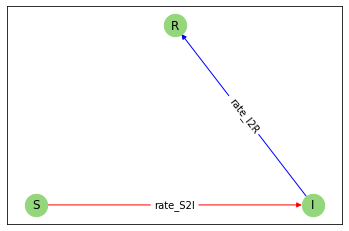

In [4]:
input_vars = {
    'beta': 0.07,
}
model.run(input_vars=input_vars)

The model output is an `xarray.Dataset`, which is very similar to an N-dimensional numpy array. We can also see the compartment graph generated when the model was run. The compartment graph defined by the user shows allowed transitions in the model. Here, we see that S -> I (`rate_S2I`) and I -> R (`rate_I2R`) transitions are allowed.

We can plot the state of the simulation over time:

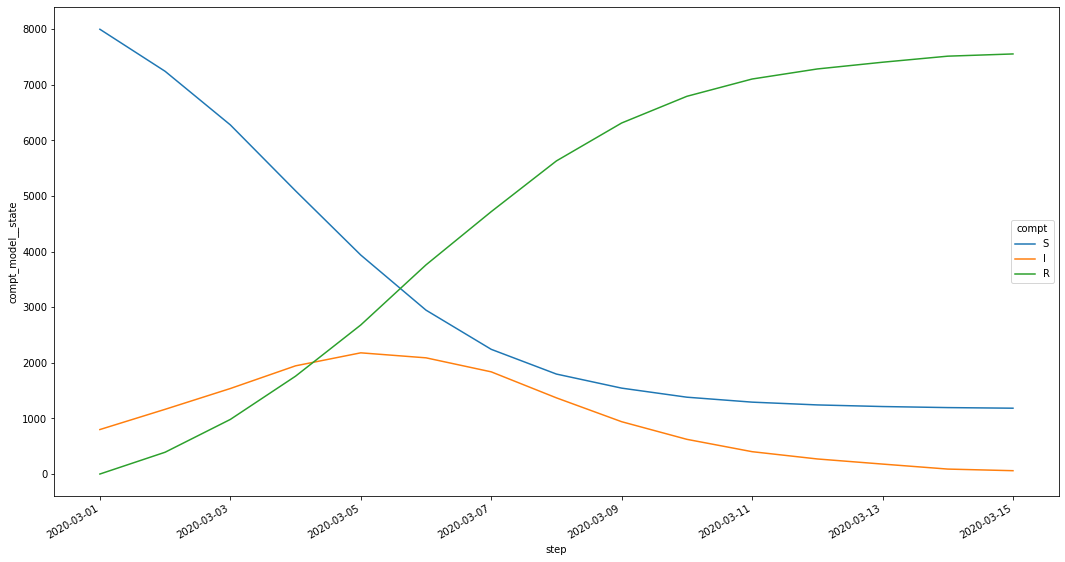

In [5]:
model.plot()

## Modify an Existing Model: Adding a Vaccination Compartment
----

We now want to add more heterogeneity into our model. We will do this in two ways:
1. Add a vaccination compartment
2. Add a socio-economic status (SES) dimension

Episimlab models are highly modular, so we can easily reuse our existing `ExampleSIR` model instead of writing the new model from scratch. To do this, we will write a few new processes and add them to our existing model:
1. A new process `CustomSetupComptGraph` that generates a compartment graph containing a new `V` node, with new directed edges `(S, V)` and `(V, I)`
2. A new process `RateS2V` that calculates an edge weight `rate_S2V`
3. A new process `RateV2I` that calculates an edge weight `rate_V2I`
4. A process `CustomSetupCoords` that includes an `ses` dimension, replacing the default `SetupCoords` process

### #1: Add a `V` Compartment

To add our "vaccinated" compartment, we need to write a new process `CustomSetupComptGraph` as described above. A "process" is just a Python class with some special features:
- Methods named `initialize`, `run_step`, `finalize_step`, and `finalize` are run automatically at different points in the simulation.
- Variables defined near the beginning of the process can be imported to exported to other processes in the model. In this case, we're exporting the variable `compt_model`.

In [6]:
@xs.process
class CustomSetupComptGraph:
    """A single process in the model. Defines the directed graph `compt_graph`
    that defines the compartments and allowed transitions between them.
    """
    compt_graph = xs.global_ref('compt_graph', intent='out')

    def initialize(self):
        """This method is run once at the beginning of the simulation."""
        self.compt_graph = self.get_compt_graph()
    
    def run_step(self):
        """This method doesn't do anything and is run once at every step
        of the simulation.
        """
        pass

    def finalize(self):
        """This method is run once at the end of the simulation."""
        self.visualize()

    def get_compt_graph(self) -> nx.DiGraph:
        """A method that returns a compartment graph as a directed
        graph. Uses the networkx package.
        """
        g = nx.DiGraph()
        g.add_nodes_from([
            ('S', {"color": "red"}),
            ('I', {"color": "blue"}),
            ('R', {"color": "green"}),
            ('V', {"color": "purple"}), # new
        ])
        g.add_edges_from([
            ('S', 'V', {"priority": 0, "color": "purple"}), # new
            ('S', 'I', {"priority": 0, "color": "red"}),
            ('V', 'I', {"priority": 1, "color": "pink"}), # new
            ('I', 'R', {"priority": 2, "color": "blue"}),
        ])
        return g
    
    def visualize(self):
        """Visualize the compartment graph, saving as a file at a path."""
        return visualize_compt_graph(self.compt_graph)

Now that we've written our new process, let's add it to our model:

In [7]:
sirv_model = model.clone()
sirv_model.setup_compt_graph

<SetupComptGraph 'setup_compt_graph' (xsimlab process)>
Variables:
    compt_graph    [out] ---> compt_model.compt_graph
Simulation stages:
    initialize
    finalize

In [8]:
sirv_model = model.update_processes({
    'setup_compt_graph': CustomSetupComptGraph
})
sirv_model.setup_compt_graph

<CustomSetupComptGraph 'setup_compt_graph' (xsimlab process)>
Variables:
    compt_graph    [out] ---> compt_model.compt_graph
Simulation stages:
    initialize
    run_step
    finalize

Let's try running our model with the new compartment graph:

INFO:root:No path to config (`config_fp`) was specified. Using model defaults.


<xarray.Dataset>
Dimensions:                   (age: 5, compt: 4, step: 15, vertex: 4, risk: 2)
Coordinates:
  * age                       (age) object '0-4' '5-17' '18-49' '50-64' '65+'
  * compt                     (compt) object 'S' 'I' 'R' 'V'
  * risk                      (risk) object 'low' 'high'
  * step                      (step) datetime64[ns] 2020-03-01 ... 2020-03-15
  * vertex                    (vertex) object 'Austin' 'Houston' ... 'Dallas'
Data variables:
    compt_model__state        (step, vertex, compt, age, risk) float64 200.0 ...
    rate_I2R__gamma           float64 0.5
    rate_S2I__beta            float64 0.07
    setup_seed__seed_entropy  int64 12345
    setup_sto__sto_toggle     int64 0

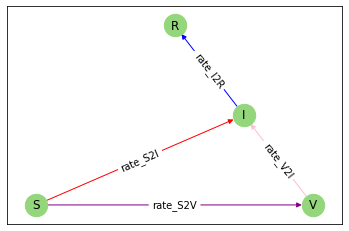

In [9]:
sirv_model.run()

The new model runs, and we get an informative warning at every step. We have defined a new compartment `V` and defined its edges to other departments, but the model still doesn't know what the **weight** of these edges are.

### #2: Calculate `rate_S2V`

To fix the warning, we need only write a new process that calculates and exports edge weights for the S -> V and V -> I transitions that we defined. Let's start by calculating the edge weight of S -> V, which by convention is named `rate_S2V`. 

In [10]:
@xs.process
class RateS2V:
    """A single process in the model. Calculates a vaccination rate
    `rate_S2V`.
    """
    # Define a variable that will be imported from other processes
    vacc_per_day = xs.variable(global_name='vacc_per_day', intent='in')
    
    # Define a variable that we want to export
    # We include the `groups=['tm']` in order for the model to recognize
    # this variable as an edge weight.
    rate_S2V = xs.variable(global_name='rate_S2V', groups=['tm'], intent='out')
    
    def initialize(self):
        """If the vaccination rate were constant, we need only need to set
        it once at the beginning of the simulation. Since we want the rate
        to change at a given time, we instead define it in the `run_step`
        method below.
        """
        pass
    
    @xs.runtime(args=['step'])
    def run_step(self, step):
        """Calculate the `rate_S2V` at every step of the simulation.
        Set the rate to zero after step 5.
        """
        if step > 5:
            self.rate_S2V = 0.
        else:
            self.rate_S2V = self.vacc_per_day

### #3 Calculate `rate_V2I`

Similarly, let's write a process that defines a `rate_V2I`. This rate will be calculated similarly to force of infection (FOI), so we will **inherit** the existing process `BaseFOI` and modify it in the **child** class `RateV2I`. The `BaseFOI` process has methods like `foi` that we can reuse in the child process.

In [11]:
@xs.process
class RateV2I(BaseFOI):
    """A single process in the model. Calculates a force of infection
    for vaccinated persons `rate_V2I`. This process inherits from the
    parent class BaseFOI.
    """
    # Override the default behavior: calculate FOI based on the population
    # of the V compartment, instead of the S compartment
    S_COMPT_LABELS = ['V']
    
    # Like before, we define a variable that we export in this process
    rate_V2I = xs.variable(dims=('age', 'risk', 'vertex'), 
                           global_name='rate_V2I', groups=['tm'], 
                           intent='out')
    
    # We also define an input variable that scales FOI
    vacc_efficacy = xs.variable(global_name='vacc_efficacy', intent='in')
    
    phi = xs.global_ref('phi', intent='in')
    
    def run_step(self):
        """Calculate the `rate_V2I` at every step of the simulation. Here,
        we make use of the `foi` method in the parent process BaseFOI.
        """
        self.rate_V2I = self.foi.sum('compt') * (1 - self.vacc_efficacy)

Finally, add both processes to the model:

In [12]:
sirv_model = sirv_model.update_processes({
    'setup_compt_graph': CustomSetupComptGraph,
    'rate_S2V': RateS2V,
    'rate_V2I': RateV2I
})
sirv_model

<xsimlab.Model (11 processes, 7 inputs)>
setup_compt_graph
setup_coords
setup_state
setup_phi
rate_S2I
    beta              [in]
setup_sto
    sto_toggle        [in]
rate_I2R
    gamma             [in]
setup_seed
    seed_entropy      [in]
rate_V2I
    beta              [in]
    vacc_efficacy     [in]
rate_S2V
    vacc_per_day      [in]
compt_model

We can now run our model, inspect the compartment graph, and plot the results:

INFO:root:No path to config (`config_fp`) was specified. Using model defaults.


<xarray.Dataset>
Dimensions:                   (age: 5, compt: 4, step: 15, vertex: 4, risk: 2)
Coordinates:
  * age                       (age) object '0-4' '5-17' '18-49' '50-64' '65+'
  * compt                     (compt) object 'S' 'I' 'R' 'V'
  * risk                      (risk) object 'low' 'high'
  * step                      (step) datetime64[ns] 2020-03-01 ... 2020-03-15
  * vertex                    (vertex) object 'Austin' 'Houston' ... 'Dallas'
Data variables:
    compt_model__state        (step, vertex, compt, age, risk) float64 200.0 ...
    rate_I2R__gamma           float64 0.5
    rate_S2I__beta            float64 0.07
    rate_S2V__vacc_per_day    int64 10
    rate_V2I__beta            float64 0.07
    rate_V2I__rate_V2I        (step, age, risk, vertex) float64 0.0 ... 0.03352
    rate_V2I__vacc_efficacy   float64 0.9
    setup_seed__seed_entropy  int64 12345
    setup_sto__sto_toggle     int64 0

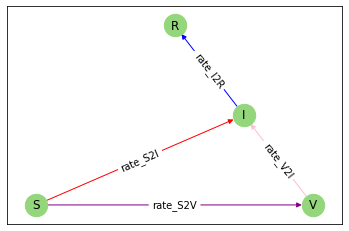

In [13]:
sirv_model.run(
    input_vars={
        'vacc_efficacy': 0.9,
        'vacc_per_day': 10,
        'sto_toggle': 0,
        'rate_I2R__gamma': 0.5
    },
    output_vars={
        'compt_model__state': 'step',
        'rate_V2I__rate_V2I': 'step'
    })

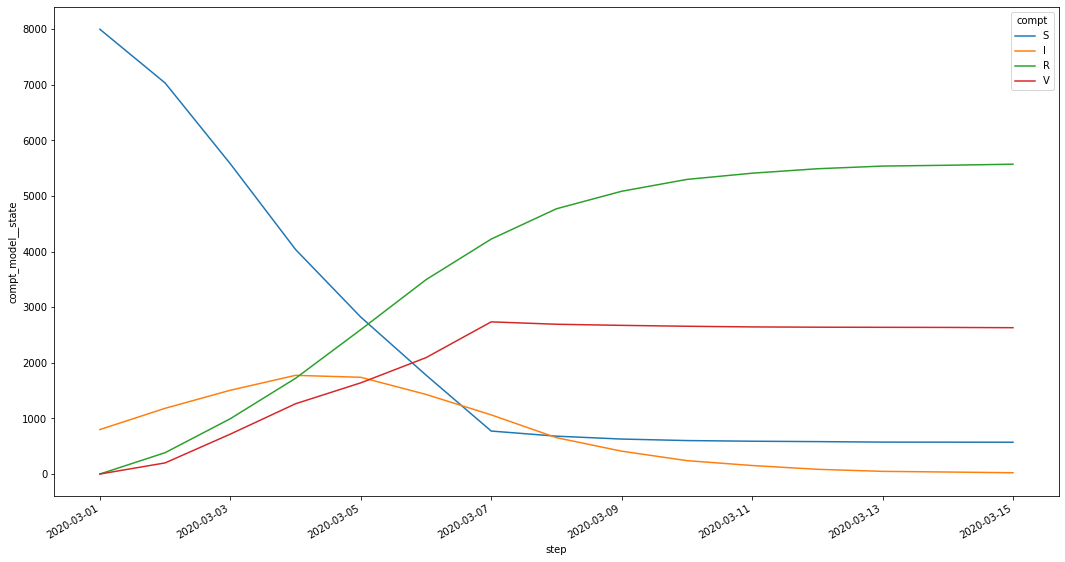

In [14]:
sirv_model.plot()

### #4: Adding a Dimension
----

Episimlab allows users to set arbitrary dimensions for their models. This means that we can easily introduce extra heterogeneity into the model by, for instance, adding a dimension that represents social vulnerability index (`svi`).

In [15]:
@xs.process
class SetupSVICoords:
    """
    """
    svi = xs.index(dims=('svi',), groups=['coords'], global_name='svi_coords')
    
    def initialize(self):
        svi = ['low', 'high']

In [ ]:
@xs.process
class ScaleBetaSVI:
    """
    """
    beta = xs.global_ref('beta', intent='inout')
    
    def initialize(self):
        